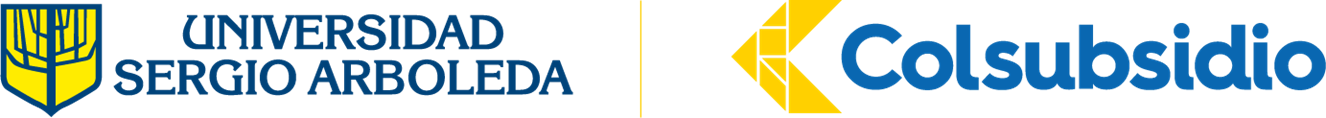


# Actividad: Detectando HAM, SPAM y SMISHING con Machine Learning
### Objetivo de la actividad

- Reconocer características clave de mensajes que permiten clasificarlos como HAM (legítimos), SPAM (correo basura), o SMISHING (fraude vía SMS).

- Construir y entrenar un modelo de machine learning (Random Forest, SVM y Red Neuronal) con un dataset real.

- Probar textos de ejemplo y propios en un programa en Colab que extraiga automáticamente indicadores como:

  *   Palabras sospechosas frecuentes
  *   Presencia de URL
  *   Presencia de direcciones de correo electrónico
  *   Presencia de números de teléfono o dígitos

- Evaluar el desempeño del modelo con métricas de clasificación y reflexionar sobre qué señales son más útiles en la predicción.

### Instrucciones
El programa en Colab debe contener:

1. Carga del dataset

  - [Dataset](https://data.mendeley.com/datasets/f45bkkt8pr/1) puedes unsarlo en ingles pero también lo puedes traducir.

  - Columnas: LABEL, TEXT, URL, EMAIL, PHONE.

2. Preprocesamiento y limpieza

  - Normalización de etiquetas (HAM, SPAM, SMISHING).
  - Conversión de indicadores URL, EMAIL, PHONE a binario (0/1).
  - Limpieza básica del texto para análisis de palabras.
3. Extracción de características (features)
  - Top 20 palabras más frecuentes de cada clase (sin palabras comunes).
  - Features manuales:
    - Presencia de URL
    - Presencia de EMAIL
    - Número de dígitos

4. Entrenamiento de modelos
  - División 80/20 del dataset.
  - Random Forest con features.
5. Evaluación de modelos
  - Métricas: Accuracy, classification report y matriz de confusión.
  - Gráfico de importancia de features (para Random Forest).

6. Prueba de predicciones
  - Textos de ejemplo ya definidos en el notebook (HAM, SPAM y SMISHING).

7. Una función interactiva para escribir su propio mensaje y el modelo lo clasifique.

Base de datos usada:  
mishra, sandhya; Soni, Devpriya (2022), “SMS PHISHING DATASET FOR MACHINE LEARNING AND PATTERN RECOGNITION”, Mendeley Data, V1, doi: 10.17632/f45bkkt8pr.1
link: https://data.mendeley.com/datasets/f45bkkt8pr/1

## Instalamos las bibliotecas usadas

In [1]:
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.8 MB/s eta 0:00:00


## Librerías

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from deep_translator import GoogleTranslator
import time
from collections import Counter
import re
from wordcloud import WordCloud

## Base de datos

In [3]:
# Subir el archivo CSV

uploaded=files.upload()
archivo=list(uploaded.keys())[0]

# Cargar el DataFrame
df = pd.read_csv(archivo)


# Mostrar las primeras filas para verificar
df

Saving Dataset_5971.csv to Dataset_5971.csv


,LABEL,TEXT,URL,EMAIL,PHONE
0,ham,Your opinion about me? 1. Over 2. Jada 3. Kusr...,No,No,No
1,ham,What's up? Do you want me to come online? If y...,No,No,No
2,ham,So u workin overtime nigpun?,No,No,No
3,ham,"Also sir, i sent you an email about how to log...",No,No,No
4,Smishing,Please Stay At Home. To encourage the notion o...,No,No,No
...,...,...,...,...,...
5966,ham,:( but your not here....,No,No,No
5967,ham,Becoz its &lt;#&gt; jan whn al the post ofic...,No,No,No
5968,ham,Its a valentine game. . . send dis msg to all ...,No,No,No
5969,ham,We r outside already.,No,No,No


### Traducción texto base de datos (Opcional)

In [4]:
def traducir(texto):
    try:
        return GoogleTranslator(source='en', target='es').translate(texto)
    except:
        return texto  # si falla, devuelve original

# Traducir solo una muestra (para ahorrar tiempo)
df["TEXTO"] = df["TEXT"].apply(traducir)

# Guardar nuevo dataset traducido
df.to_csv("sms_phishing_es.csv", index=False)

In [30]:
df = pd.read_csv("sms_phishing_es.csv")
df

,LABEL,TEXT,URL,EMAIL,PHONE,TEXTO
0,ham,Your opinion about me? 1. Over 2. Jada 3. Kusr...,No,No,No,Tu opinión sobre mi? 1. Más de 2. Jada 3. Kusr...
1,ham,What's up? Do you want me to come online? If y...,No,No,No,¿Qué pasa? ¿Quieres que me conecte? Si eres li...
2,ham,So u workin overtime nigpun?,No,No,No,¿Entonces trabajas en tiempo extra Nigpun?
3,ham,"Also sir, i sent you an email about how to log...",No,No,No,"También señor, le envié un correo electrónico ..."
4,Smishing,Please Stay At Home. To encourage the notion o...,No,No,No,"Por favor, quédese en casa. Para alentar la no..."
...,...,...,...,...,...,...
5966,ham,:( but your not here....,No,No,No,:( pero no estás aquí ...
5967,ham,Becoz its &lt;#&gt; jan whn al the post ofic...,No,No,No,Becoz its & lt;#& gt; Jan Whn al El puesto de...
5968,ham,Its a valentine game. . . send dis msg to all ...,No,No,No,Es un juego de San Valentín. . . Envía dis msg...
5969,ham,We r outside already.,No,No,No,Ya estamos afuera.


## Preprocesamiento y limpieza

### Normalización de etiquetas (HAM, SPAM, SMISHING).


In [21]:
df['LABEL'].unique()

array(['ham', 'Smishing', 'spam', 'Spam', 'smishing'], dtype=object)

In [62]:
import seaborn as sns
df['LABEL'] = df['LABEL'].astype(str).str.strip().str.upper()
df['LABEL'].unique()

array(['HAM', 'SMISHING', 'SPAM'], dtype=object)

LABEL
HAM         4844
SMISHING     638
SPAM         489
Name: count, dtype: int64


/tmp/ipython-input-2339206125.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_clases.index, y=conteo_clases.values, palette="viridis")


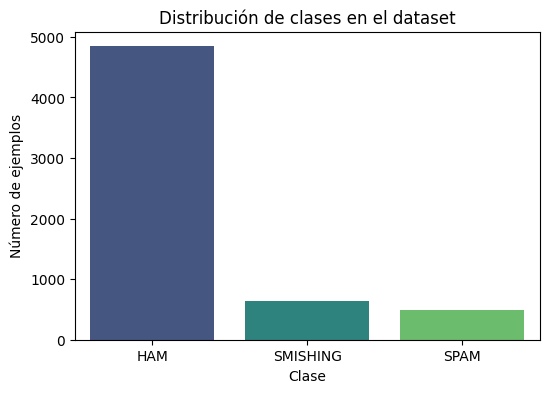

In [63]:
conteo_clases = df["LABEL"].value_counts()
print(conteo_clases)

plt.figure(figsize=(6,4))
sns.barplot(x=conteo_clases.index, y=conteo_clases.values, palette="viridis")
plt.title("Distribución de clases en el dataset")
plt.ylabel("Número de ejemplos")
plt.xlabel("Clase")
plt.show()

### Conversión de indicadores URL, EMAIL, PHONE a binario (0/1).


In [32]:
for col in ["URL","EMAIL","PHONE"]:
    df[col] = df[col].map({"No":0, "yes":1})

          URL  EMAIL  PHONE
LABEL                      
HAM         8      1      7
SMISHING  100     11    527
SPAM       99      7    310


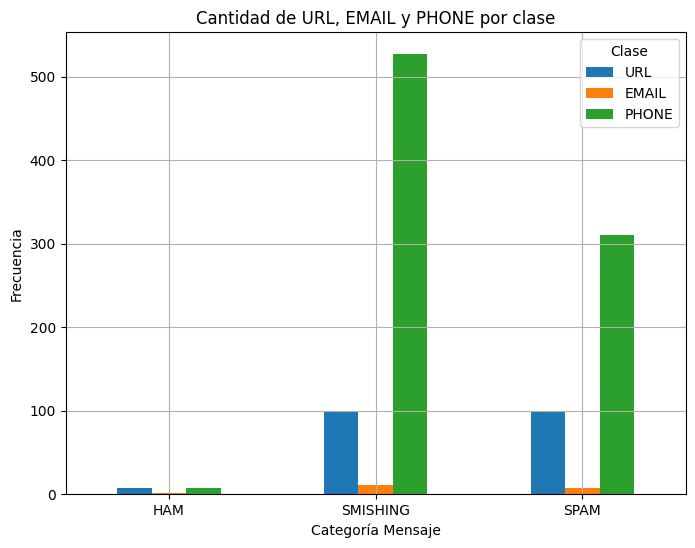

In [33]:


# Conteo por clase
conteo = df.groupby("LABEL")[["URL","EMAIL","PHONE"]].sum()
print(conteo)

# Gráfico
conteo.plot(kind="bar", figsize=(8,6))
plt.title("Cantidad de URL, EMAIL y PHONE por clase")
plt.ylabel("Frecuencia")
plt.xlabel("Categoría Mensaje")
plt.xticks(rotation=0)
plt.legend(title="Clase")
plt.grid()
plt.show()

In [34]:
print(conteo)

          URL  EMAIL  PHONE
LABEL                      
HAM         8      1      7
SMISHING  100     11    527
SPAM       99      7    310


### Limpieza básica del texto para análisis de palabras.

In [37]:
# Rellenar NaN con string vacío
df["TEXTO"] = df["TEXTO"].fillna("")

# Función de limpieza robusta
def limpiar(texto):
    texto = str(texto).lower()  # asegurar string
    texto = re.sub(r"[^a-záéíóúüñ\s]", "", texto)  # quitar caracteres raros
    return texto

df["clean"] = df["TEXTO"].apply(limpiar)

Palabras comunes


🔹 Palabras más comunes en HAM:
de: 2204
que: 1977
no: 1500
en: 1424
a: 1360
la: 1102
y: 1024
el: 973
es: 832
un: 797


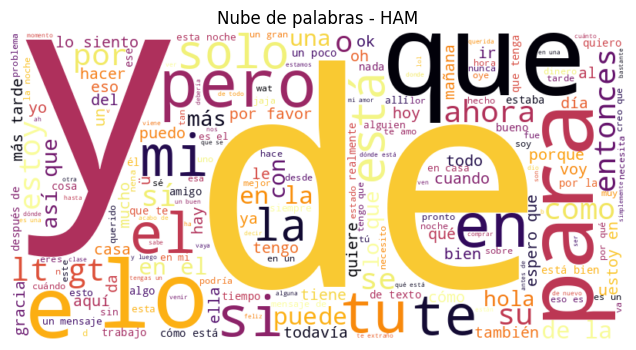


🔹 Palabras más comunes en SMISHING:
de: 1307
al: 427
llame: 354
su: 341
para: 336
en: 290
un: 288
a: 233
la: 211
premio: 187


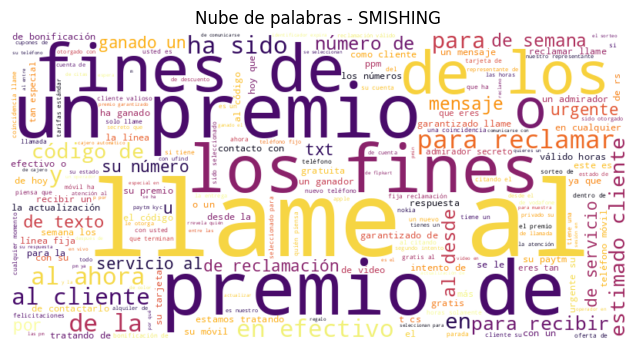


🔹 Palabras más comunes en SPAM:
de: 743
a: 350
para: 235
en: 211
y: 189
la: 161
al: 157
el: 136
su: 135
ahora: 130


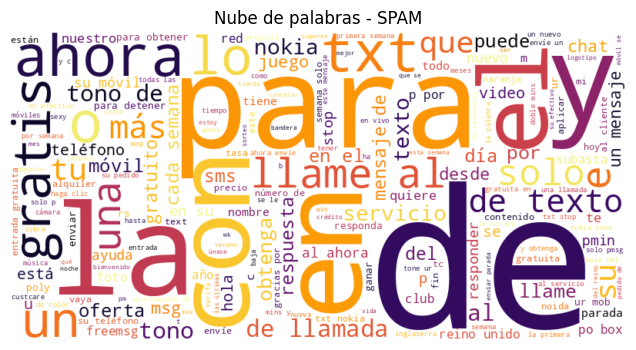

In [38]:

for clase in df["LABEL"].unique():
    textos = " ".join(df[df["LABEL"] == clase]["clean"])
    palabras = textos.split()
    conteo = Counter(palabras).most_common(10)

    print(f"\n🔹 Palabras más comunes en {clase}:")
    for palabra, freq in conteo:
        print(f"{palabra}: {freq}")

    # Nube de palabras
    if textos.strip():  # evitar errores si está vacío
        wc = WordCloud(width=800, height=400, background_color="white", colormap="inferno").generate(textos)
        plt.figure(figsize=(8,4))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Nube de palabras - {clase}")
        plt.show()


Eliminamos palabras comunes

In [39]:
palabras_comunes = {'de','que','no','en','a','la','y','el','es','un','una','los','las','al','del',
         'lo','se','por','con','para','su','sus','tu','tus','te','le','les','me','mi','mis',
         'ya','como','si','o','u','e','pero','mas','más','sin','sobre','esto','esta','este',
         'esa','ese','aqui','aquí','alli','allí','ahi','ahí','sr','sra','ud','uds','d','q','desde',''}


🔹 Top 10 palabras en HAM:
estoy: 456
está: 364
qué: 316
estás: 313
ahora: 297
bien: 295
solo: 294
cuando: 251
cómo: 237
entonces: 225
tengo: 214
eso: 206
día: 204
casa: 200
tarde: 199
hola: 199
así: 199
puedo: 171
noche: 171
siento: 160


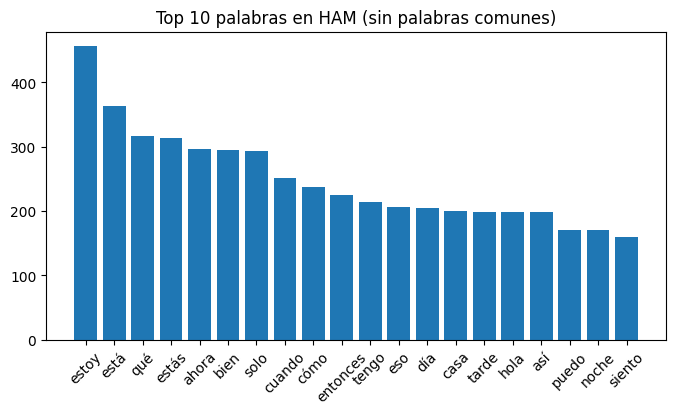


🔹 Top 10 palabras en SMISHING:
llame: 354
premio: 187
cliente: 145
ahora: 124
fines: 101
móvil: 91
urgente: 87
teléfono: 81
reclamar: 76
ganado: 70
nuestro: 69
estimado: 68
semana: 66
solo: 66
efectivo: 64
sido: 63
garantizado: 61
paytm: 61
reclamación: 59
desde: 58


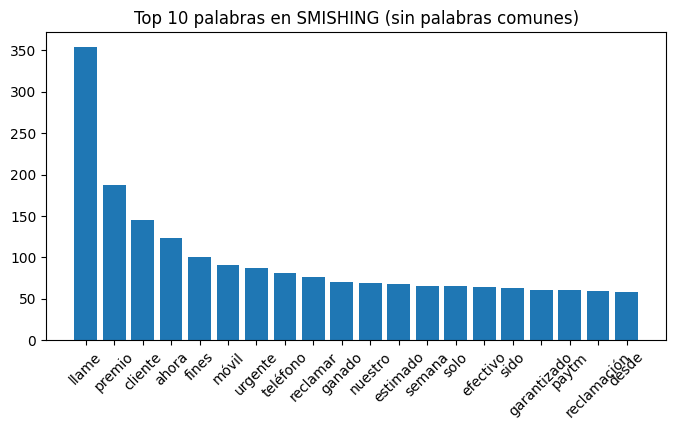


🔹 Top 10 palabras en SPAM:
ahora: 130
txt: 117
llame: 99
solo: 95
texto: 86
gratis: 79
semana: 70
tono: 69
nokia: 56
llamada: 53
móvil: 52
mensaje: 41
obtenga: 41
envíe: 36
servicio: 36
gratuita: 34
chat: 33
stop: 33
efectivo: 31
cada: 30


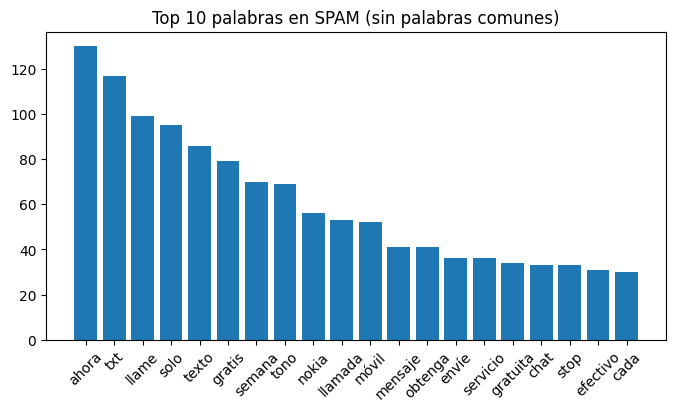

In [41]:
for clase in df["LABEL"].unique():
    textos = " ".join(df[df["LABEL"] == clase]["clean"])
    palabras = [p for p in textos.split() if p not in palabras_comunes and len(p) > 2]
    conteo = Counter(palabras).most_common(20)

    print(f"\n🔹 Top 10 palabras en {clase}:")
    for palabra, freq in conteo:
        print(f"{palabra}: {freq}")

    # Gráfico
    if conteo:
        palabras, freqs = zip(*conteo)
        plt.figure(figsize=(8,4))
        plt.bar(palabras, freqs)
        plt.title(f"Top 10 palabras en {clase} (sin palabras comunes)")
        plt.xticks(rotation=45)
        plt.show()

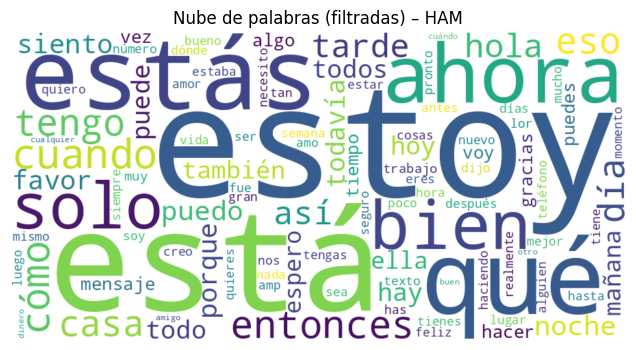

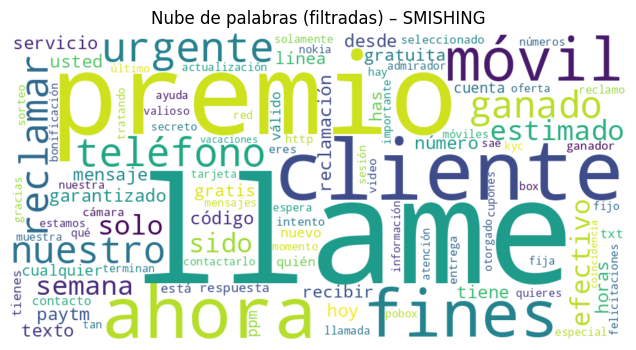

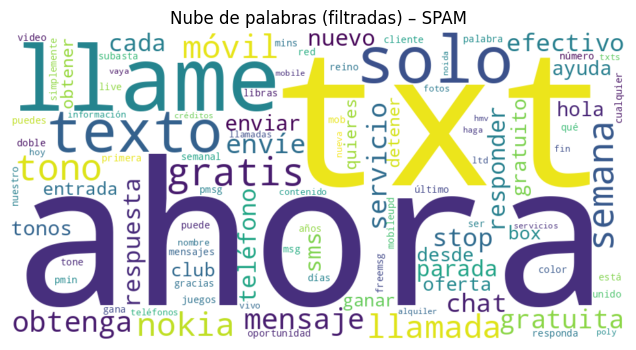

In [44]:
for clase in df["LABEL"].unique():
    textos = " ".join(df.loc[df["LABEL"] == clase, "clean"])
    tokens = [t for t in textos.split() if t not in palabras_comunes and len(t) > 2]
    freqs = dict(Counter(tokens).most_common(100))  # toma las más frecuentes
    if freqs:
        wc = WordCloud(width=900, height=450, background_color="white")
        plt.figure(figsize=(9,4))
        plt.imshow(wc.generate_from_frequencies(freqs), interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Nube de palabras (filtradas) – {clase}")
        plt.show()
        print("")

## Modelo

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Modelo 1 (features manuales)
from sklearn.ensemble import RandomForestClassifier

# Modelo 2 (texto crudo)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# Modelo 3 (red neuronal)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout

### Features

In [50]:
df

,LABEL,TEXT,URL,EMAIL,PHONE,TEXTO,clean
0,HAM,Your opinion about me? 1. Over 2. Jada 3. Kusr...,0,0,0,Tu opinión sobre mi? 1. Más de 2. Jada 3. Kusr...,tu opinión sobre mi más de jada kusruthi l...
1,HAM,What's up? Do you want me to come online? If y...,0,0,0,¿Qué pasa? ¿Quieres que me conecte? Si eres li...,qué pasa quieres que me conecte si eres libre ...
2,HAM,So u workin overtime nigpun?,0,0,0,¿Entonces trabajas en tiempo extra Nigpun?,entonces trabajas en tiempo extra nigpun
3,HAM,"Also sir, i sent you an email about how to log...",0,0,0,"También señor, le envié un correo electrónico ...",también señor le envié un correo electrónico s...
4,SMISHING,Please Stay At Home. To encourage the notion o...,0,0,0,"Por favor, quédese en casa. Para alentar la no...",por favor quédese en casa para alentar la noci...
...,...,...,...,...,...,...,...
5966,HAM,:( but your not here....,0,0,0,:( pero no estás aquí ...,pero no estás aquí
5967,HAM,Becoz its &lt;#&gt; jan whn al the post ofic...,0,0,0,Becoz its & lt;#& gt; Jan Whn al El puesto de...,becoz its lt gt jan whn al el puesto de ofic...
5968,HAM,Its a valentine game. . . send dis msg to all ...,0,0,0,Es un juego de San Valentín. . . Envía dis msg...,es un juego de san valentín envía dis msg a ...
5969,HAM,We r outside already.,0,0,0,Ya estamos afuera.,ya estamos afuera


In [52]:
def top_words_for_class(df, label, k=20):
    textos = " ".join(df.loc[df["LABEL"] == label, "clean"])
    palabras = [p for p in textos.split() if p not in palabras_comunes and len(p) > 2]
    return [w for w, _ in Counter(palabras).most_common(k)]

top_ham = top_words_for_class(df, "HAM", 20)
top_spam = top_words_for_class(df, "SPAM", 20)
top_smish = top_words_for_class(df, "SMISHING", 20)

# unir las tres listas y quitar duplicados
top_features_words = list(set(top_ham + top_spam + top_smish))
print("Número de palabras seleccionadas:", len(top_features_words))


def extract_features(row):
    text = str(row["clean"]).lower()
    feats = {}
    # Presencia de palabras clave
    for w in top_features_words:
        feats[f"word_{w}"] = int(w in text)
    # Features manuales
    feats["url"] = row["URL"]
    feats["email"] = row["EMAIL"]
    feats["digits"] = sum(c.isdigit() for c in text)
    return feats

feat_df = df.apply(extract_features, axis=1, result_type="expand")
feat_df["LABEL"] = df["LABEL"]

Número de palabras seleccionadas: 52


In [54]:
def extract_features(row):
    text = str(row["clean"]).lower()
    feats = {}
    # Presencia de palabras clave
    for w in top_features_words:
        feats[f"word_{w}"] = int(w in text)
    # Features manuales
    feats["url"] = row["URL"]
    feats["email"] = row["EMAIL"]
    feats["digits"] = sum(c.isdigit() for c in text)
    return feats

feat_df = df.apply(extract_features, axis=1, result_type="expand")
feat_df["LABEL"] = df["LABEL"]

In [55]:
feat_df

,word_reclamación,word_nokia,word_teléfono,word_efectivo,word_envíe,word_qué,word_txt,word_llamada,word_desde,word_estás,...,word_bien,word_entonces,word_texto,word_así,word_mensaje,word_casa,url,email,digits,LABEL
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,HAM
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,HAM
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,HAM
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,HAM
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,SMISHING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5966,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,HAM
5967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,HAM
5968,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,HAM
5969,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,HAM


In [56]:
X = feat_df.drop(columns=["LABEL"])
y = feat_df["LABEL"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [67]:
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

In [68]:
print("\n=== MODELO 1 (Top palabras + features manuales) ===")
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))


=== MODELO 1 (Top palabras + features manuales) ===
Accuracy: 0.9364016736401674
              precision    recall  f1-score   support

         HAM       0.97      0.99      0.98       969
    SMISHING       0.86      0.74      0.79       128
        SPAM       0.67      0.67      0.67        98

    accuracy                           0.94      1195
   macro avg       0.83      0.80      0.82      1195
weighted avg       0.93      0.94      0.94      1195

Confusion matrix:
 [[958   4   7]
 [  8  95  25]
 [ 20  12  66]]


#### Importancia de características

/tmp/ipython-input-3950103806.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette="magma")


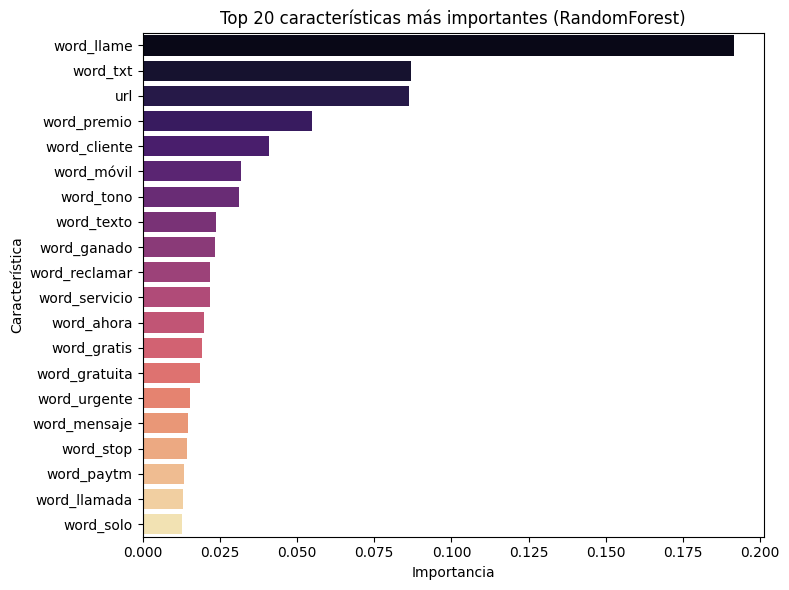

In [69]:

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Tomamos las 20 más importantes
top_n = 20
top_features = X.columns[indices[:top_n]]
top_importances = importances[indices[:top_n]]

plt.figure(figsize=(8,6))
sns.barplot(x=top_importances, y=top_features, palette="magma")
plt.title(f"Las {top_n} características más importantes (RandomForest)")
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.tight_layout()
plt.show()

#### Textos de ejemplo

In [73]:
import re

ejemplos = [
    "Hola Juan, nos vemos mañana en la oficina a las 10am.",  # HAM
    "Gana un iPhone gratis ahora!!! Solo visita http://promo-bit.ly/ganar",  # SPAM
    "Su cuenta bancaria será BLOQUEADA. Llame al 3001234567 de inmediato.",  # SMISHING
    "Estimado cliente, hemos detectado actividad sospechosa en su correo. Escríbanos a soporte@banco.com",  # phishing
    "Te mando el informe por correo interno, revisa y me confirmas."  # HAM
]

#Extraemos caracteristicas
def extraer_features_texto(texto):
    text = str(texto).lower()
    feats = {}
    # Palabras clave  que usamos para entrenar
    for w in top_features_words:
        feats[f"word_{w}"] = int(w in text)
    # URL
    feats["url"] = int(bool(re.search(r"(https?://|www\.|\.com|bit\.ly)", text)))
    # EMAIL
    feats["email"] = int(bool(re.search(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", text)))
    # Phone (7 o más dígitos consecutivos)
    feats["digits"] = len(re.findall(r"\d", text))
    return feats

# pasamos a DF
ejemplo_feats = pd.DataFrame([extraer_features_texto(t) for t in ejemplos])

#
ejemplo_feats = ejemplo_feats.reindex(columns=X.columns, fill_value=0)

# predicción
predicciones = rf.predict(ejemplo_feats)

# Mostrar resultados
for texto, pred in zip(ejemplos, predicciones):
    print(f"\nTexto: {texto}")
    print(f"Predicción del modelo: {pred}")



Texto: Hola Juan, nos vemos mañana en la oficina a las 10am.
Predicción del modelo: HAM

Texto: Gana un iPhone gratis ahora!!! Solo visita http://promo-bit.ly/ganar
Predicción del modelo: SPAM

Texto: Su cuenta bancaria será BLOQUEADA. Llame al 3001234567 de inmediato.
Predicción del modelo: SMISHING

Texto: Estimado cliente, hemos detectado actividad sospechosa en su correo. Escríbanos a soporte@banco.com
Predicción del modelo: SMISHING

Texto: Te mando el informe por correo interno, revisa y me confirmas.
Predicción del modelo: HAM


In [66]:
ejemplo_feats

,word_reclamación,word_nokia,word_teléfono,word_efectivo,word_envíe,word_qué,word_txt,word_llamada,word_desde,word_estás,...,word_urgente,word_bien,word_entonces,word_texto,word_así,word_mensaje,word_casa,url,email,digits
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
